In [1]:
import torch
import json
import os

from scalarize.robust_experiment_utils import (
    get_robust_set_utility,
    get_decision_input,
    get_problem_variables,
)
from scalarize.utils.scalarization_objectives import (
    get_scalarized_samples,
    get_utility_mcobjective,
)

from math import pi
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
loc = f"data/truss_kl_hv_general_0.4"

config_path = loc + "/config.json"
with open(config_path, "r") as f:
    kwargs = json.load(f)

num_iterations = kwargs["num_iterations"]
num_initial_points = kwargs["num_initial_points"]
tkwargs = {"dtype": torch.double, "device": "cpu"}
num_seeds = 100

function_name = kwargs["function_name"]
scalarization_kwargs = kwargs["scalarization_kwargs"]
util_kwargs = kwargs["util_kwargs"]
sampling_kwargs = kwargs["sampling_kwargs_util"]
robust_kwargs = kwargs["robust_kwargs"]
environment_kwargs = kwargs["environment_kwargs"]
input_transform_kwargs = kwargs["input_transform_kwargs"]
perturbation_kwargs = kwargs["perturbation_kwargs_util"]

problem_variables = get_problem_variables(
    function_name=function_name,
    tkwargs=tkwargs,
    environment_kwargs=environment_kwargs,
    input_transform_kwargs=input_transform_kwargs,
)

decision_dim = problem_variables["decision_dim"]
standard_decision_bounds = problem_variables["standard_decision_bounds"]

num_scalars = sampling_kwargs["num_weights"]
num_perturbations = perturbation_kwargs["num_perturbations"]

input_transform_label = input_transform_kwargs["label"]
iteration_list = [0, 25, 50, 75, 100]

In [3]:
set_utility = get_robust_set_utility(
    function_name=function_name,
    scalarization_kwargs=scalarization_kwargs,
    util_kwargs=util_kwargs,
    sampling_kwargs=sampling_kwargs,
    robust_kwargs=robust_kwargs,
    environment_kwargs=environment_kwargs,
    input_transform_kwargs=input_transform_kwargs,
    perturbation_kwargs=perturbation_kwargs,
    tkwargs=tkwargs,
)

nadir = set_utility.scalarization_fn.ref_points
unit_vectors = set_utility.scalarization_fn.weights
indices = unit_vectors[:, 0].sort().indices
unit_vectors = unit_vectors[indices, :]

In [4]:
def get_objective_values(label, iteration_list=iteration_list, seed=1):
    all_Ys = {}
    best_Ys = {}
    best_lengths = {}

    for i in iteration_list:
        set_utility = get_robust_set_utility(
            function_name=function_name,
            scalarization_kwargs=scalarization_kwargs,
            util_kwargs=util_kwargs,
            sampling_kwargs=sampling_kwargs,
            robust_kwargs=robust_kwargs,
            environment_kwargs=environment_kwargs,
            input_transform_kwargs=input_transform_kwargs,
            perturbation_kwargs=perturbation_kwargs,
            tkwargs=tkwargs,
        )

        data_loc = f"{loc}/{str(seed).zfill(4)}_{label}.pt"
        data = torch.load(data_loc)
        X = data["X"][: num_initial_points + i]
        Z_decision = get_decision_input(
            X=X,
            input_transform_label=input_transform_label,
            decision_dim=decision_dim,
        )

        set_utility(Z_decision)

        best_Z = set_utility.best_inputs.unique(dim=0)
        Ys_best = set_utility.eval_problem(set_utility.input_transform(best_Z))
        nYs_best, _ = set_utility.outcome_transform(Ys_best)

        Y_decision = set_utility.eval_problem(set_utility.input_transform(Z_decision))
        nYs, _ = set_utility.outcome_transform(Y_decision)

        M = unit_vectors.shape[-1]
        constant = pi ** (1 / 2) / (2 * gamma(M / 2 + 1) ** (1 / M))

        all_Ys[i] = nYs
        best_Ys[i] = nYs_best
        best_lengths[i] = torch.pow(set_utility.best_values, 1 / M) / constant

    return all_Ys, best_Ys, best_lengths

In [5]:
def plot_robust_front(Y, pY, lengths):
    n = int(len(Y) / num_perturbations)
    for i in range(n):
        A = Y[i * num_perturbations : (i + 1) * num_perturbations]
        A = A[A[:, 0].sort().indices, :]
        plt.plot(A[:, 0], A[:, 1], linewidth=6, color="dodgerblue", alpha=0.1)

    pn = int(len(pY) / num_perturbations)
    for i in range(pn):
        A = pY[i * num_perturbations : (i + 1) * num_perturbations]
        A = A[A[:, 0].sort().indices, :]

        plt.plot(A[:, 0], A[:, 1], linewidth=6, color="crimson", alpha=0.5)

    dr_pareto_front = nadir + lengths[indices].unsqueeze(-1) * unit_vectors
    plt.plot(
        dr_pareto_front[:, 0], dr_pareto_front[:, 1], color="k", linewidth=5, alpha=0.75
    )

In [6]:
def plot_all_robust_fronts(all_Ys, best_Ys, best_lengths, plot_legend=False):
    fig, axes = plt.subplots(1, 5, figsize=(28, 5))
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.16
    )

    for i in range(5):
        plt.subplot(1, 5, i + 1)
        n = iteration_list[i]

        Y = all_Ys[n]
        pY = best_Ys[n]
        lengths = best_lengths[n]
        plot_robust_front(Y, pY, lengths)

        plt.yticks([])
        plt.xticks([])
        plt.title(rf"Iteration: $T$={n}", fontsize=30)
        plt.xlabel(r"$y^{(1)}$", fontsize=30)
        plt.ylabel(r"$y^{(2)}$", fontsize=30)
        plt.xlim(-0.175, 1.05)
        plt.ylim(-0.175, 1.05)
        plt.scatter(
            -0.1 * torch.ones(1),
            -0.1 * torch.ones(1),
            marker="s",
            s=200,
            color="w",
            linewidth=2,
            edgecolor="k",
        )

    if plot_legend:
        blue_line = mlines.Line2D(
            [], [], color="dodgerblue", linestyle="-", linewidth=10, alpha=0.5
        )
        red_line = mlines.Line2D(
            [], [], color="crimson", linestyle="-", linewidth=10, alpha=0.5
        )
        white_square = mlines.Line2D(
            [],
            [],
            color="w",
            marker="s",
            linestyle="None",
            markersize=15,
            markeredgecolor="k",
            markeredgewidth=2,
        )

        labels = [
            r"Points: $F(\mathbf{x}) = \{f(\mathbf{x}, \boldsymbol{\xi}) \in \mathbb{R}^M: \boldsymbol{\xi} \in \Xi\}$",
            r"Robust points: $F(\mathbf{x}^*)$, $\mathbf{x}^* \in \bigcup_{\boldsymbol{\theta} \in \Theta} \text{argmax}_{\mathbf{x} \in X_n} \inf_{q \in \mathcal{U}} \mathbb{E}_{q(\boldsymbol{\xi})}[s_{\boldsymbol{\theta}}(f(\mathbf{x}, \boldsymbol{\xi}))] $",
            r"Nadir: $\boldsymbol{\eta}$",
        ]
        handles = [blue_line, red_line, white_square]
        axes[0].legend(
            labels=labels,
            handles=handles,
            loc=(0.75, -0.6),
            ncol=2,
            fontsize=30,
        )
    plt.show()

    return fig

# Comparison

In [7]:
sobol_Ys, sobol_best_Ys, sobol_best_lengths = get_objective_values("sobol")
drui_ucb_Ys, drui_ucb_best_Ys, drui_best_lengths = get_objective_values(
    "robust-eui-ucb"
)

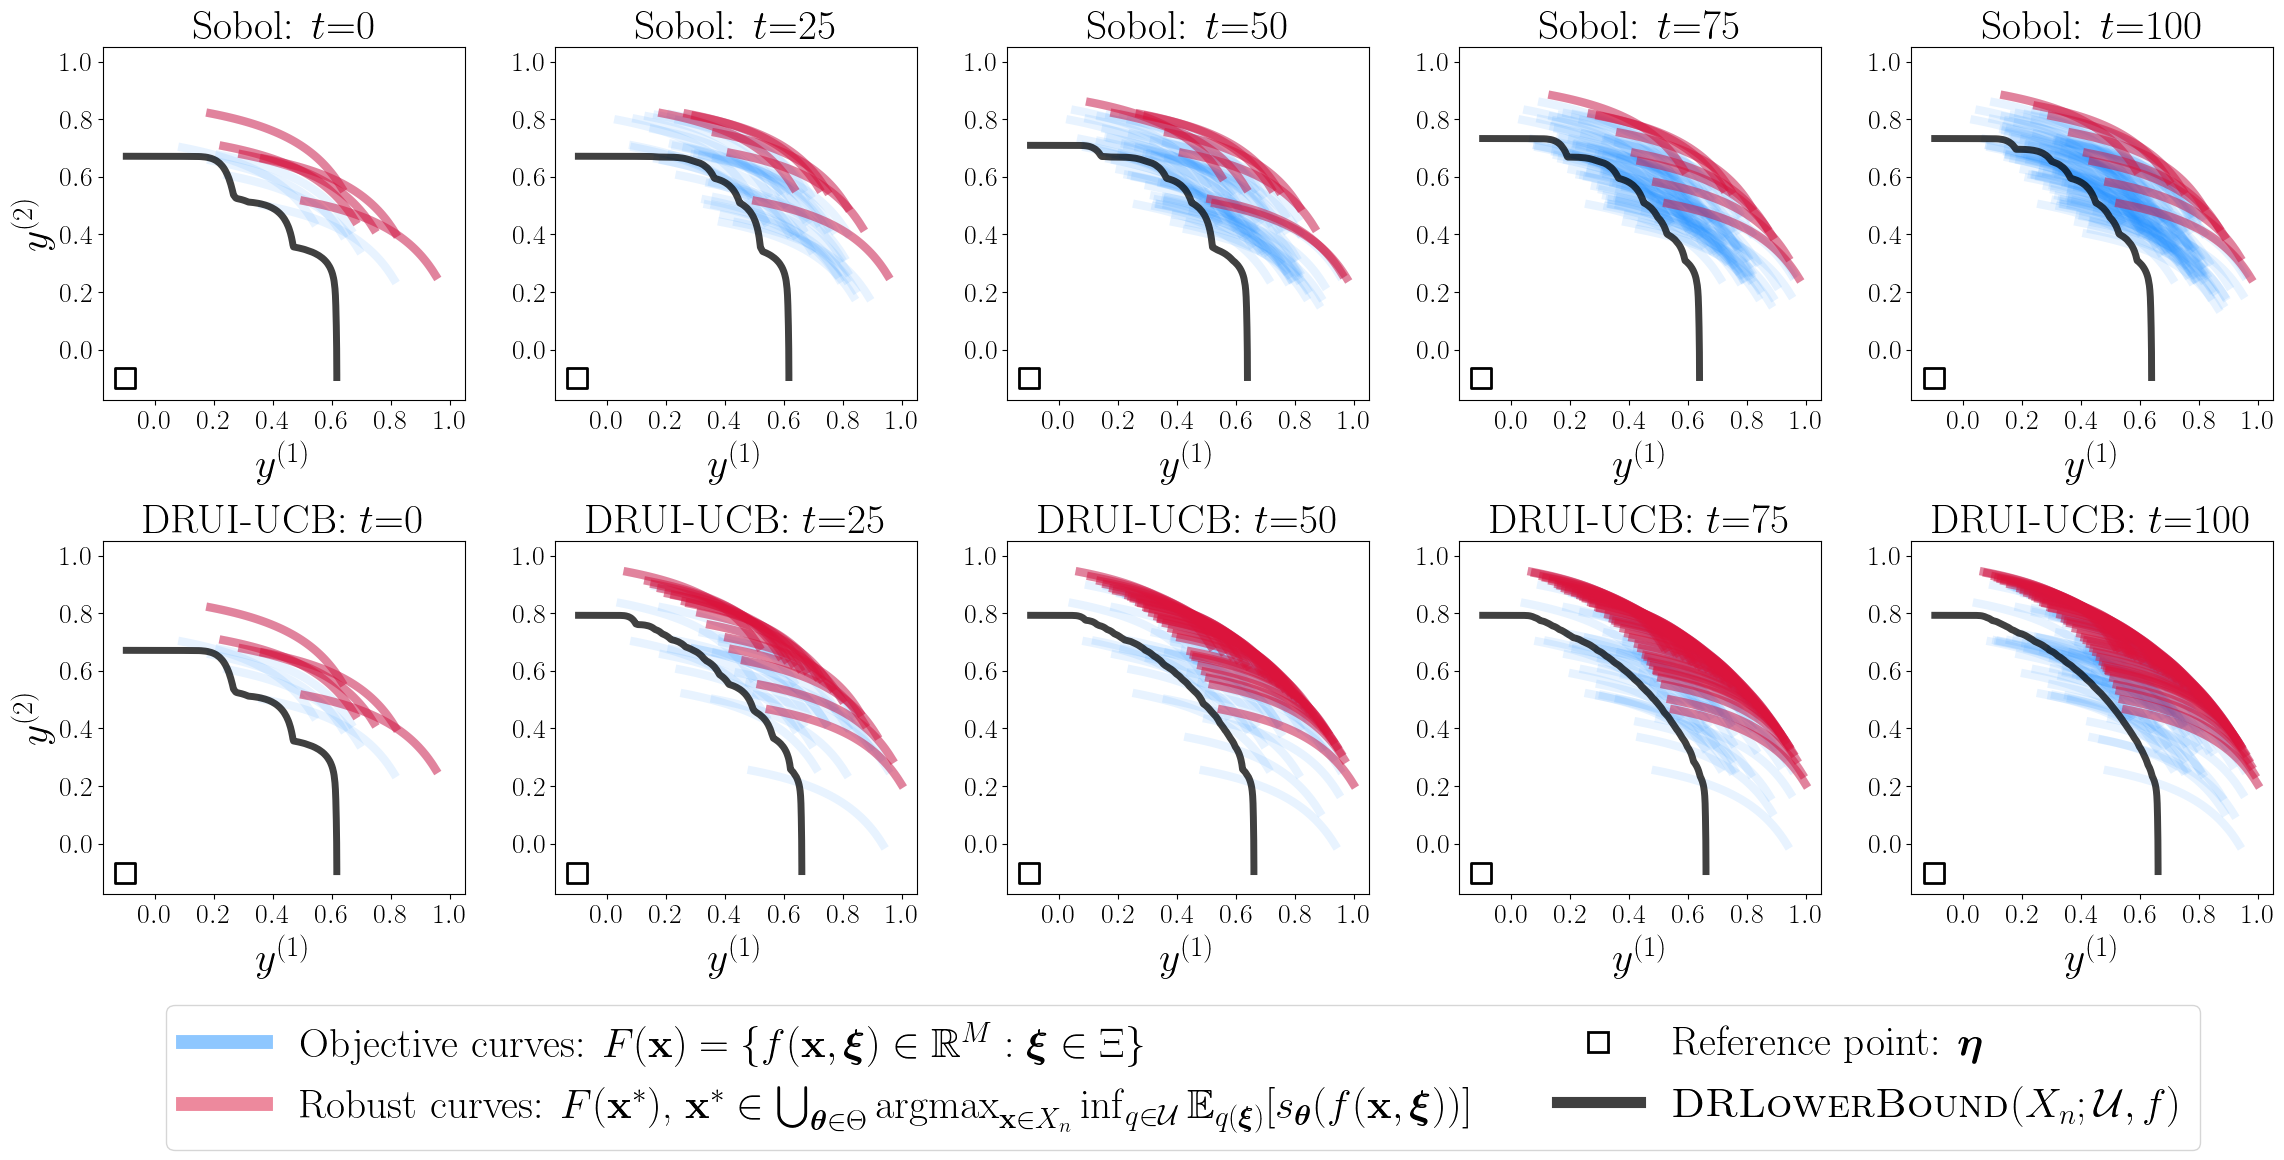

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(28, 11))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.4
)

all_Ys = [sobol_Ys, drui_ucb_Ys]
best_Ys = [sobol_best_Ys, drui_ucb_best_Ys]
best_lengths = [sobol_best_lengths, drui_best_lengths]
labels = ["Sobol", "DRUI-UCB"]

for j in range(2):
    for i in range(5):
        plt.subplot(2, 5, j * 5 + i + 1)
        n = iteration_list[i]

        Y = all_Ys[j][n]
        pY = best_Ys[j][n]
        lengths = best_lengths[j][n]
        plot_robust_front(Y, pY, lengths)

        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        plt.title(rf"{labels[j]}: $t$={n}", fontsize=30)
        plt.xlabel(r"$y^{(1)}$", fontsize=30)
        plt.xlim(-0.175, 1.05)
        plt.ylim(-0.175, 1.05)
        plt.scatter(
            -0.1 * torch.ones(1),
            -0.1 * torch.ones(1),
            marker="s",
            s=200,
            color="w",
            linewidth=2,
            edgecolor="k",
        )
        if i == 0:
            plt.ylabel(r"$y^{(2)}$", fontsize=30)


blue_line = mlines.Line2D(
    [], [], color="dodgerblue", linestyle="-", linewidth=10, alpha=0.5
)
red_line = mlines.Line2D(
    [], [], color="crimson", linestyle="-", linewidth=10, alpha=0.5
)
black_line = mlines.Line2D(
    [], [], color="black", linestyle="-", linewidth=8, alpha=0.75
)

white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=2,
)

labels = [
    r"Objective curves: $F(\mathbf{x}) = \{f(\mathbf{x}, \boldsymbol{\xi}) \in \mathbb{R}^M: \boldsymbol{\xi} \in \Xi\}$",
    r"Robust curves: $F(\mathbf{x}^*)$, $\mathbf{x}^* \in \bigcup_{\boldsymbol{\theta} \in \Theta} \text{argmax}_{\mathbf{x} \in X_n} \inf_{q \in \mathcal{U}} \mathbb{E}_{q(\boldsymbol{\xi})}[s_{\boldsymbol{\theta}}(f(\mathbf{x}, \boldsymbol{\xi}))] $",
    r"Reference point: $\boldsymbol{\eta}$",
    r"$\textsc{DRLowerBound}(X_n; \mathcal{U}, f)$",
]
handles = [blue_line, red_line, white_square, black_line]
axes[1, 0].legend(
    labels=labels,
    handles=handles,
    loc=(0.175, -0.725),
    ncol=2,
    fontsize=30,
)
plt.show()